## Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [6]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers_for_tasks import PlotROCCurve



In [12]:
output_path =r'D:\1_Teaching_Work_Folder\SMU\MITB_HealthcareAnalytics\Github\2024\Temp\Group Project-MIMIC\output_not_uploaded'
df_train = pd.read_csv(os.path.join(output_path, 'train2.csv'))
df_test = pd.read_csv(os.path.join(output_path, 'test2.csv'))
confidence_interval = 95
random_seed=0

In [14]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

,index,subject_id,hadm_id,stay_id,intime_ed,outtime_ed,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,race,edregtime,edouttime,insurance,in_year,age,before_ed_mortality,outcome_hospitalization,outcome_inhospital_mortality,ed_death,ed_los,intime_icu,outtime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,335316,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,52.0,F,2180.0,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52.0,False,True,False,False,0 days 13:30:00,2180-07-23 14:00:00,2180-07-23 23:50:47,0 days 08:06:00,True,True,1,2,2,2180-07-23 05:54:00,0 days 00:00:00,True,1,2,2,0,0,0,13.50,8.1,0.00,36.555556,87.0,14.0,97.0,71.0,43.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,36.777778,85.0,18.0,98.0,81.0,38.0,0.0,2.0,14.0,52.333333,6,4,4,3,3,2
1,56672,10000084,29888819.0,36954971,2160-12-27 18:32:00,2160-12-28 16:07:00,72.0,M,2160.0,2161-02-13,2160-12-28 05:11:00,2160-12-28 16:07:00,NaN,WHITE,2160-12-27 18:32:00,2160-12-28 16:07:00,Medicare,2160,72.0,False,True,False,False,0 days 21:35:00,NaN,NaN,NaN,False,False,0,1,1,NaN,NaN,False,0,1,1,0,0,0,21.58,NaN,NaN,37.055556,80.0,16.0,95.0,111.0,72.0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.055556,80.0,16.0,100.0,119.0,84.0,0.0,1.0,6.0,85.000000,4,9,5,1,0,1
2,0,10000115,NaN,38081480,2154-12-10 02:04:00,2154-12-10 02:16:00,24.0,M,2154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2154,24.0,False,False,False,False,0 days 00:12:00,NaN,NaN,NaN,False,False,0,0,0,2154-12-17 16:37:00,7 days 14:21:00,False,0,0,0,0,0,0,0.20,NaN,7.60,36.444444,81.0,18.0,99.0,120.0,71.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.666667,78.0,16.0,99.0,116.0,70.0,0.0,0.0,0.0,87.333333,0,0,0,0,0,1
3,335319,10000117,22927623.0,32642808,2181-11-14 21:51:00,2181-11-15 02:06:42,48.0,F,2174.0,NaN,2181-11-15 02:05:00,2181-11-15 14:52:00,NaN,WHITE,2181-11-14 21:51:00,2181-11-15 09:57:00,Other,2181,55.0,False,True,False,False,0 days 04:15:42,NaN,NaN,NaN,False,False,0,0,0,2183-07-17 10:30:00,609 days 08:23:18,False,0,0,0,0,0,0,4.26,NaN,609.35,36.444444,81.0,16.0,100.0,148.0,83.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.000000,85.0,21.0,98.0,141.0,77.0,0.0,0.0,1.0,104.666667,1,4,3,0,0,1
4,335320,10000117,NaN,30632130,2183-07-17 10:30:00,2183-07-17 10:40:00,48.0,F,2174.0,NaN,NaN,NaN,NaN,WHITE,NaN,NaN,NaN,2183,57.0,False,False,False,False,0 days 00:10:00,NaN,NaN,NaN,False,False,0,0,0,2183-09-18 08:41:00,62 days 22:01:00,False,0,0,0,0,0,0,0.17,NaN,62.92,36.166667,119.0,16.0,99.0,100.0,55.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,92.0,18.0,98.0,130.0,83.0,0.0,0.0,0.0,70.000000,1,8,5,4,4,4


### 1. task-specific filter: exclude ED death cases for train and test

In [15]:
df_train = df_train[df_train['ed_death'] == False].reset_index()
df_test = df_test[df_test['ed_death'] == False].reset_index()

### 2. Variable Selection

In [16]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [17]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [18]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,float64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [19]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [20]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.8995975931003647 : 1


### 3.  Modeling script

In [22]:
# List for all results
result_list = []

Logistic Regression:


c:\ProgramData\Anaconda3\envs\snowflakes\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 2.6092023849487305 seconds
AUC: 0.8065223290517259
AUPRC: 0.773919164795855
Sensitivity: 0.7427926738519888
Specificity: 0.7209127274291367
Score thresold: 0.44935419462557585
2.5 97.5


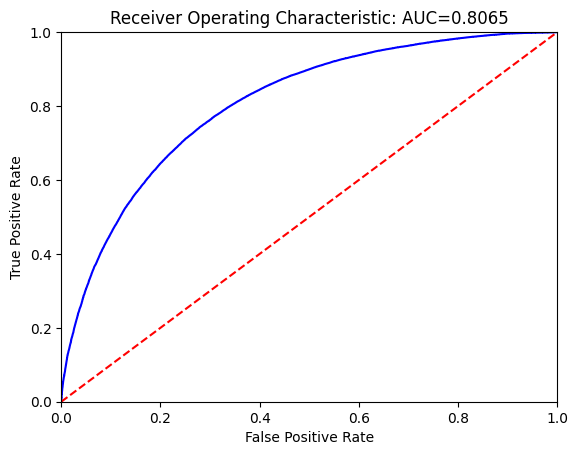

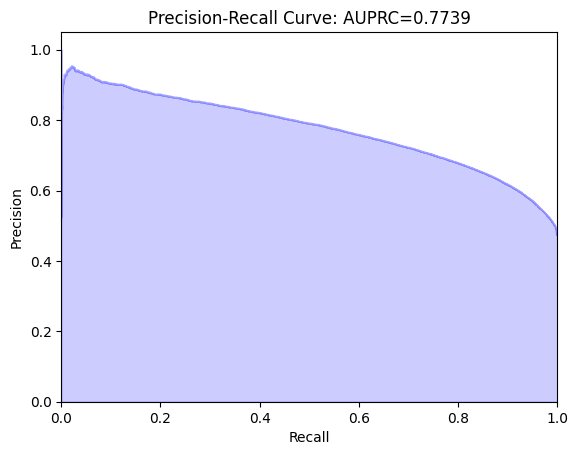

In [23]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 70.94080686569214 seconds
AUC: 0.8191888694246052
AUPRC: 0.7896780009441475
Sensitivity: 0.7487217648047241
Specificity: 0.7365908211105854
Score thresold: 0.4932718944099379
2.5 97.5


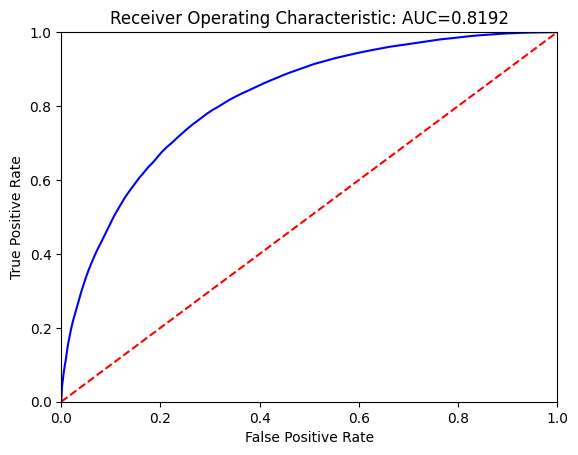

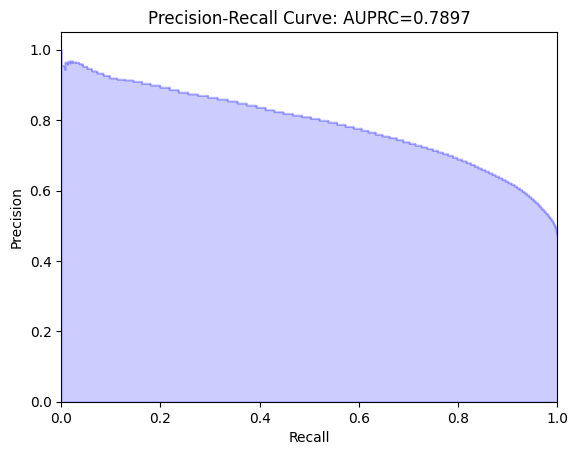

[1.25184916e-01 1.32051209e-02 7.65368409e-03 1.13666572e-02
 2.24070383e-02 6.47031598e-03 1.67825507e-02 2.69672161e-02
 1.14745138e-04 8.77671600e-04 2.34698246e-03 7.87900852e-02
 8.56929282e-02 3.97011387e-02 4.31198650e-02 8.72955510e-02
 8.32704953e-02 4.71077760e-02 1.13397222e-01 6.75821639e-03
 8.93919961e-03 5.01930494e-03 5.36880230e-04 4.26202602e-03
 2.83479755e-03 3.89787677e-03 4.29059005e-03 3.53503500e-03
 4.16065447e-03 3.14702560e-03 5.08724355e-03 3.03077096e-03
 3.05040156e-03 1.41129514e-03 6.17378528e-03 2.18465413e-03
 1.54363716e-03 3.86512268e-03 6.36953494e-03 3.34413517e-03
 1.26968947e-03 6.29023844e-03 4.54547146e-03 1.44682609e-03
 1.96469913e-03 1.07212183e-03 7.30616959e-03 2.93127734e-03
 2.46785018e-03 5.65742530e-03 1.11240752e-02 4.57642986e-03
 4.26781292e-03 9.80751563e-04 4.09696323e-03 4.79761027e-03
 3.63105558e-03 1.21512123e-02 1.18794125e-03 3.39770079e-03
 4.69847107e-03 4.09637956e-03 2.85755451e-03 7.99012575e-03]


In [24]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 58.87962770462036 seconds
AUC: 0.8176111587636775
AUPRC: 0.7941399033931478
Sensitivity: 0.746921433543772
Specificity: 0.7319239537184394
Score thresold: 0.48328284088500867
2.5 97.5


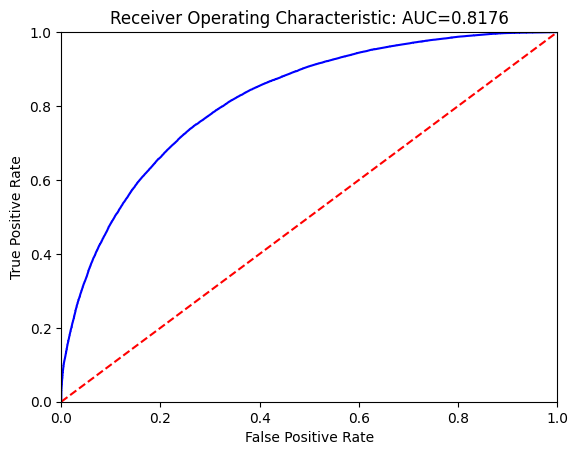

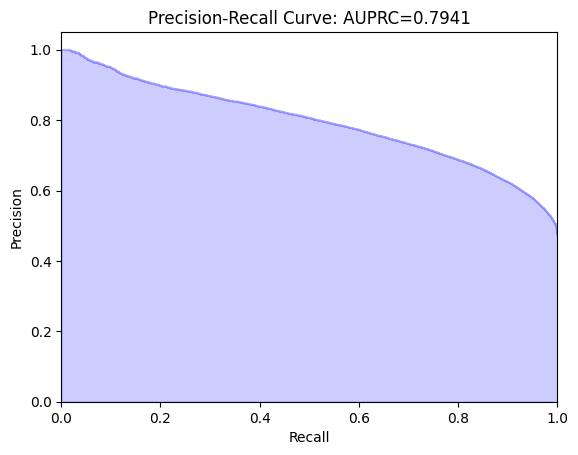

In [18]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [25]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [26]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1764/1764 [==============================] - 5s 2ms/step - loss: 0.5704 - accuracy: 0.7099 - auc: 0.7787 - auprc: 0.7505 - true_positives: 110653.0000 - true_negatives: 139691.0000 - precision: 0.7066 - recall: 0.6626
Epoch 2/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.5411 - accuracy: 0.7261 - auc: 0.8016 - auprc: 0.7774 - true_positives: 114912.0000 - true_negatives: 141147.0000 - precision: 0.7209 - recall: 0.6881
Epoch 3/20
1764/1764 [==============================] - 4s 2ms/step - loss: 0.5341 - accuracy: 0.7300 - auc: 0.8065 - auprc: 0.7822 - true_positives: 117213.0000 - true_negatives: 140208.0000 - precision: 0.7207 - recall: 0.7019
Epoch 4/20
1764/1764 [==============================] - 4s 2ms/step - loss: 0.5284 - accuracy: 0.7336 - auc: 0.8107 - auprc: 0.7868 - true_positives: 119304.0000 - true_negatives: 139395.0000 - precision: 0.7207 - recall: 0.7144
Epoch 5/20
1764/1764 [==============================] - 7s 4ms/step - loss: 0.5267 -

INFO:tensorflow:Assets written to: hospitalization_triage_mlp\assets


MLP:
2755/2755 [==============================] - 3s 953us/step
AUC: 0.8214943829762745
AUPRC: 0.7986350181243029
Sensitivity: 0.7644926666506637
Specificity: 0.7214718912641405
Score thresold: 0.45601028
2.5 97.5


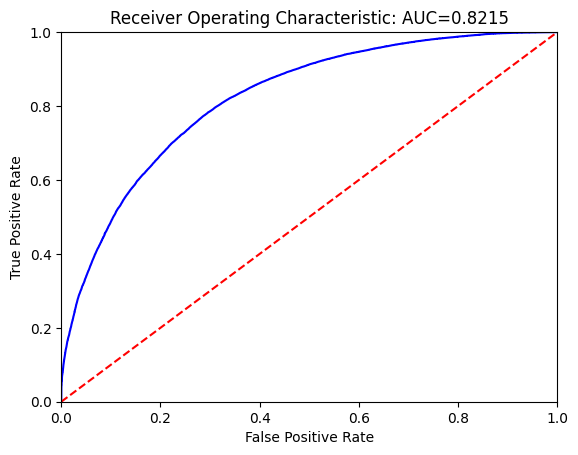

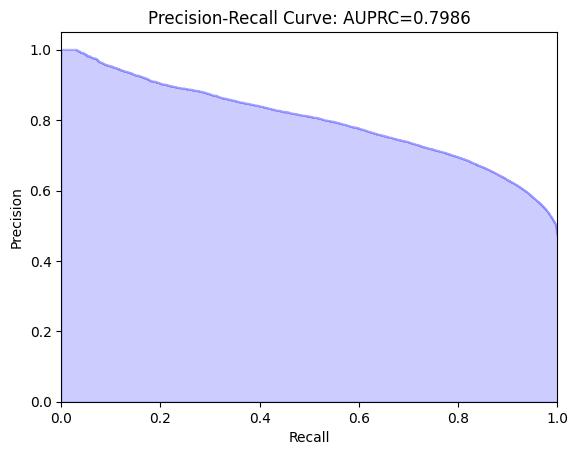

In [27]:
print("MLP:")
mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [28]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


score_NEWS
AUC: 0.5798769155123751
AUPRC: 0.5555466972504828
Sensitivity: 0.5643198348496123
Specificity: 0.5406899221471891
Score thresold: 1
2.5 97.5


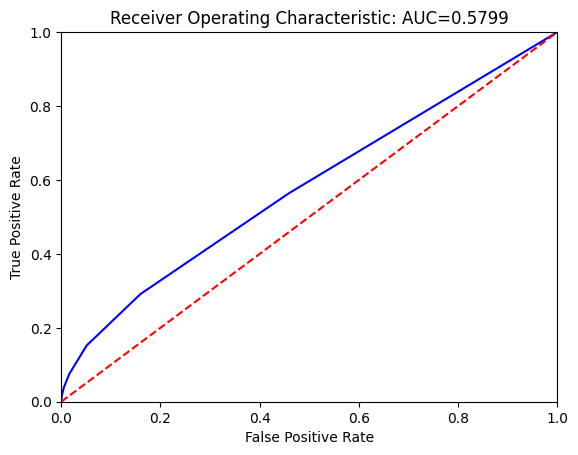

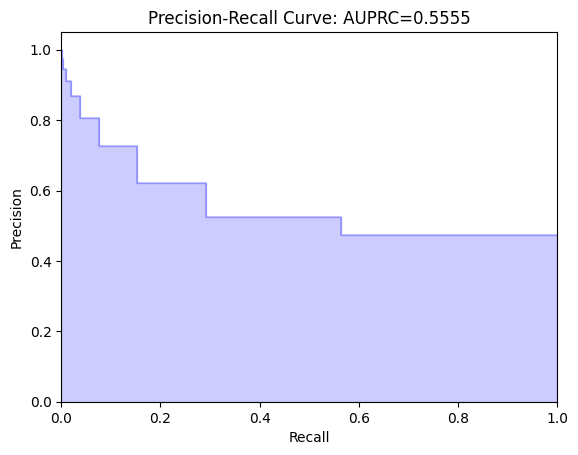

In [29]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5617647490314268
AUPRC: 0.5377071156285826
Sensitivity: 0.5173671955639838
Specificity: 0.5635511204783001
Score thresold: 1
2.5 97.5


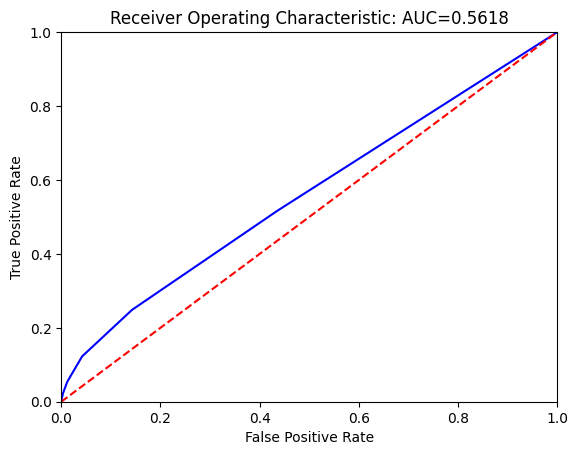

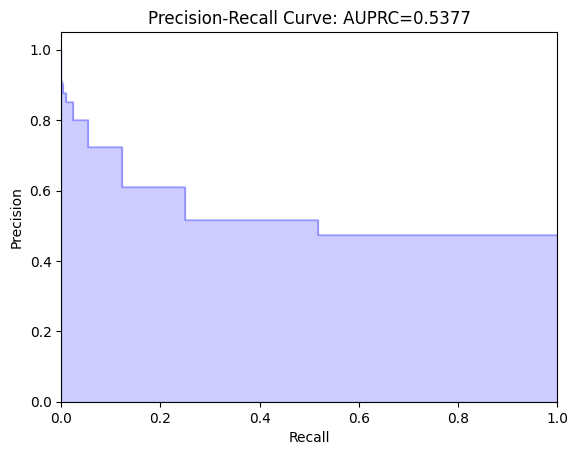

In [30]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6712338935476605
AUPRC: 0.6068127496487556
Sensitivity: 0.7140353825103819
Specificity: 0.5583250892511507
Score thresold: 3
2.5 97.5


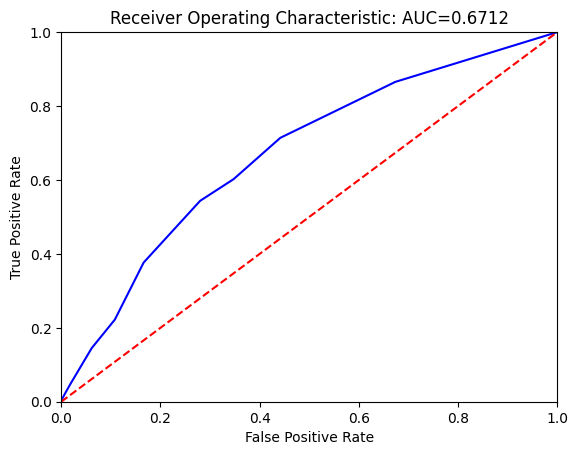

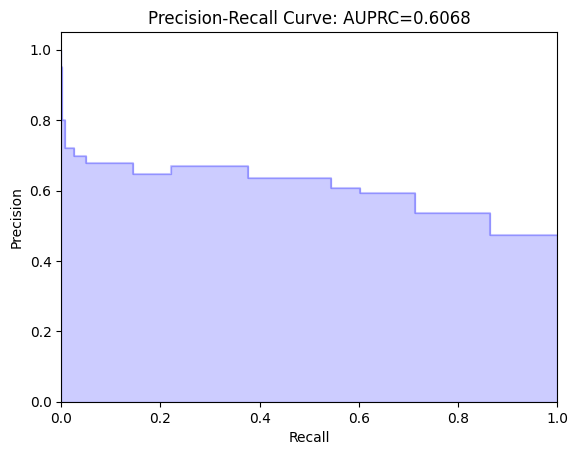

In [31]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5580235939721568
AUPRC: 0.5214109214590648
Sensitivity: 0.29863894956672027
Specificity: 0.8096692330852939
Score thresold: 2
2.5 97.5


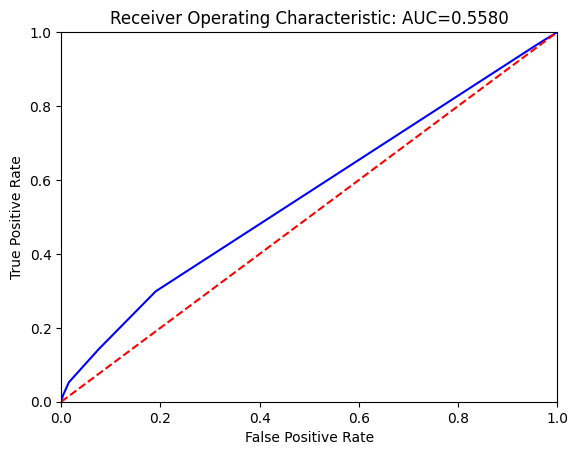

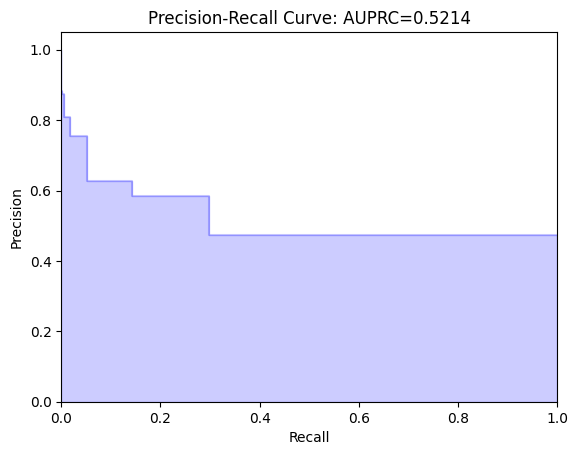

In [32]:
get_score_performance("score_MEWS", random_seed=random_seed)

### 4. Performance output

In [33]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.449,0.807 (0.804-0.809),0.774 (0.769-0.777),0.743 (0.728-0.749),0.721 (0.716-0.735),2.609
1,RF,0.493,0.819 (0.817-0.821),0.79 (0.785-0.793),0.749 (0.745-0.762),0.737 (0.724-0.739),70.941
2,MLP,0.456,0.821 (0.819-0.824),0.799 (0.795-0.801),0.764 (0.749-0.77),0.721 (0.714-0.736),148.685
3,score_NEWS,1.000,0.58 (0.576-0.583),0.556 (0.551-0.558),0.564 (0.559-0.568),0.541 (0.536-0.545),0.000
4,score_NEWS2,1.000,0.562 (0.558-0.565),0.538 (0.532-0.54),0.517 (0.512-0.521),0.564 (0.559-0.568),0.000
5,score_REMS,3.000,0.671 (0.669-0.674),0.607 (0.603-0.609),0.714 (0.656-0.718),0.558 (0.555-0.609),0.000
6,score_MEWS,2.000,0.558 (0.556-0.561),0.521 (0.517-0.524),0.299 (0.295-0.303),0.81 (0.807-0.813),0.000


In [34]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.125185
18,triage_acuity,0.113397
15,triage_sbp,0.087296
12,triage_heartrate,0.085693
16,triage_dbp,0.083270
11,triage_temperature,0.078790
17,triage_pain,0.047108
14,triage_o2sat,0.043120
13,triage_resprate,0.039701
7,n_hosp_365d,0.026967
